<h1>superVision</h1>

Python implementation of <em>Who supervises the supervisor? Model monitoring in production using deep feature embeddings with applications to workpiece inspection</em> (https://arxiv.org/abs/2201.06599) to be presented at the 8th International Conference on Machine Vision and Machine Learning (MVML'22) (https://mvml.org)

It is recommended to select a GPU for model training and inference (steps in google colab: select <em>view ressources</em> in RAM/Disk dropdown menu; select <em>change runtime type</em>; select GPU as hardware accelerator).


---



<em>Background:</em>

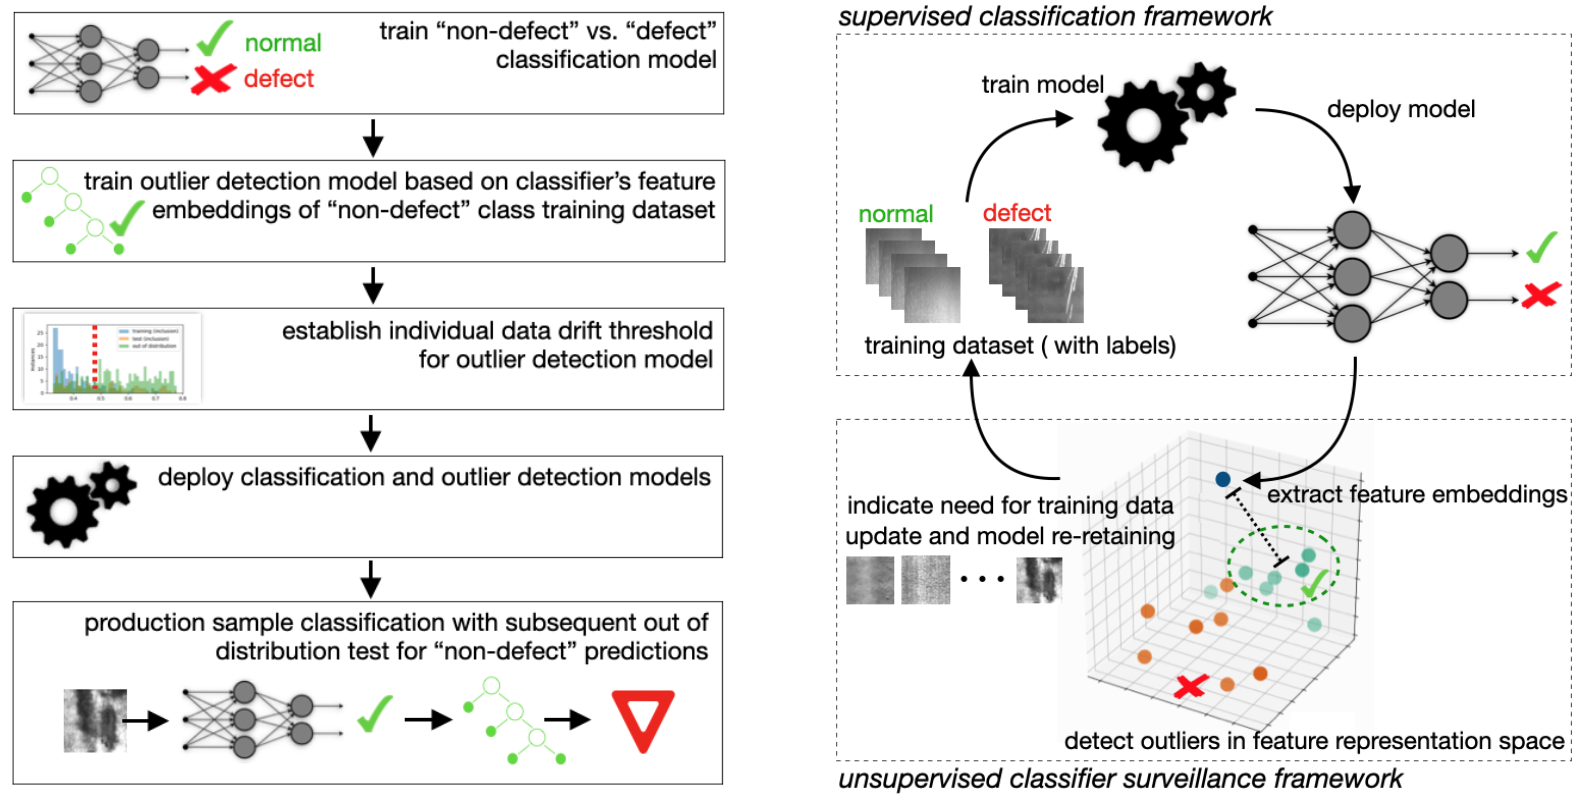

 The automation of condition monitoring and workpiece inspection plays an essential role in maintaining high quality as well as high throughput of the manufacturing process. To this end, the recent rise of developments in machine learning has lead to vast improvements in the area of autonomous process supervision. However, the more complex and powerful these models become, the less transparent and explainable they generally are as well. One of the main challenges is the monitoring of live deployments of these machine learning systems and raising alerts when encountering events that might impact model performance. In particular, supervised classifiers are typically build under the assumption of stationarity in the underlying data distribution. For example, a visual inspection system trained on a set of material surface defects generally does not adapt or even recognize gradual changes in the data distribution - an issue known as "data drift" - such as the emergence of new types of surface defects. This, in turn, may lead to detrimental mispredictions, e.g. samples from new defect classes being classified as non-defective. To this end, it is desirable to provide real-time tracking of a classifier's performance to inform about the putative onset of additional error classes and the necessity for manual intervention with respect to classifier re-training. Here, we propose an unsupervised framework that acts on top of a supervised classification system, thereby harnessing its internal deep feature representations as a proxy to track changes in the data distribution during deployment and, hence, to anticipate classifier performance degradation. 



Create a tmp folder (if not already existing) and get (and unzip) the reformatted NEU dataset (located on cloud2.paar-it.de)

In [ ]:
!mkdir -p tmp

In [ ]:
!wget --no-check-certificate "https://cloud2.paar-it.de/f/8322806b5355426ca3f9/?dl=1" -O tmp/NEU_split.zip

--2022-08-26 11:29:11--  https://cloud2.paar-it.de/f/8322806b5355426ca3f9/?dl=1
Resolving cloud2.paar-it.de (cloud2.paar-it.de)... 46.189.64.172
Connecting to cloud2.paar-it.de (cloud2.paar-it.de)|46.189.64.172|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud2.paar-it.de/seafhttp/files/76c96cda-9cd9-46f2-9b8a-059ed0e7579d/NEU_split.zip [following]
--2022-08-26 11:29:12--  https://cloud2.paar-it.de/seafhttp/files/76c96cda-9cd9-46f2-9b8a-059ed0e7579d/NEU_split.zip
Reusing existing connection to cloud2.paar-it.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 56524442 (54M) [application/zip]
Saving to: ‘tmp/NEU_split.zip’

tmp/NEU_split.zip   100%[===================>]  53.91M  2.10MB/s    in 26s     

2022-08-26 11:29:38 (2.06 MB/s) - ‘tmp/NEU_split.zip’ saved [56524442/56524442]



In [ ]:
!unzip tmp/NEU_split.zip -d tmp/

The NEU dataset used for experiment I in the paper
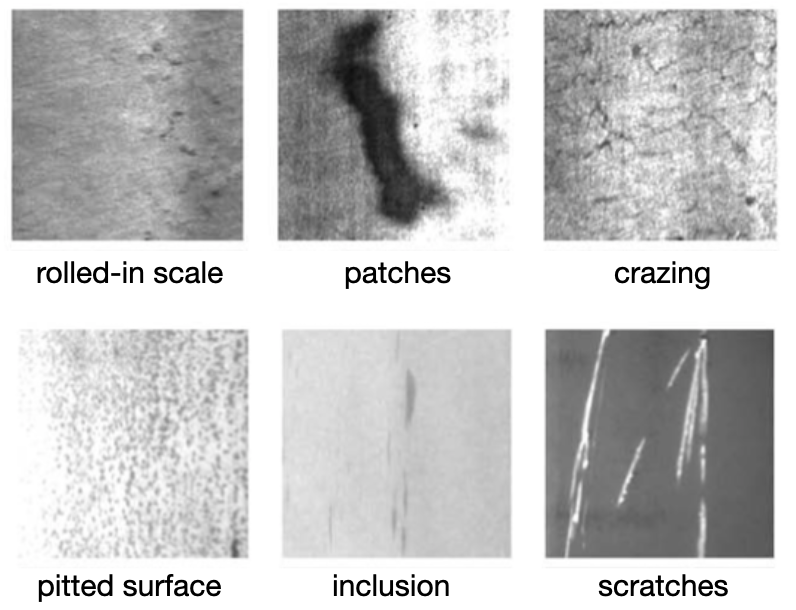

Klassen Abkuerzungen:
rolled-in scale (RS);
patches (Pa);
crazing (Cr);
pitted surface (PS);
inclusion (In);
scratches (Sc);

In [ ]:

import os 

base_dir = "tmp/NEU_split"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# define classes (identical to folder names in train and test)
CLASSES = ['In', 'Sc', 'Cr', 'PS', 'Pa', 'RS']

In [ ]:
# import dependencies
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from collections import Counter
from random import sample

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dense, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model, load_model

from scipy import stats
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt

%matplotlib inline

Now, let's build the supervised classifier as well as the classifier's supervisor 

In [ ]:

class Classifier:
    """Generic binary supervised classifier"""

    def __init__(self, dims = 1024, img_width=200, img_height=200):
        """init classifier model"""
        self._dims = dims
        self._w = img_width
        self._h = img_height
        self.model = None 
        self._init_model()

    def _init_model(self, num_classes: int = 2) -> None:
        """Build model from (pre-trained on imagenet dataset) mobilenet model as backbone and add custom classification head"""
        base_model = MobileNet(weights='imagenet', include_top=False)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(self._dims, activation='relu')(x)
        preds = Dense(num_classes, activation='softmax')(x)
        self.model = Model(inputs=base_model.input, outputs=preds)
        base_model.trainable = False

    def summary(self):
        """Get a summary of the model architecture"""
        self.model.summary()

    def predict(self, data: np.array):
        """Use model to predict from data provided as numpy array"""
        return self.model.predict(data)

    def predict_generator(self, generator):
        """Use model to predict from data given generator"""
        return self.model.predict(generator)

    def train(self, train_dir, classes, batch_size = 16, epochs = 15, optimizer="adam", 
              loss='categorical_crossentropy', metrics=['accuracy'], 
              validation_split=0.2, use_class_weights = False):
        """Compile and train the model with data augmentation """

        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        self.train_datagen = ImageDataGenerator(rescale=1. / 255,
                                                shear_range=0.2,
                                                zoom_range=0.2,
                                                horizontal_flip=True,
                                                vertical_flip=True,
                                                validation_split=validation_split)

        self.train_generator = self.train_datagen.flow_from_directory(train_dir,
                                                                    target_size=(self._h, self._w),
                                                                    batch_size=batch_size,
                                                                    class_mode='categorical',
                                                                    shuffle=False,
                                                                    subset='training',
                                                                    classes=classes)

        self.val_generator = self.train_datagen.flow_from_directory(train_dir,
                                                                    target_size=(self._h, self._w),
                                                                    batch_size=batch_size,
                                                                    class_mode='categorical',
                                                                    shuffle=True,
                                                                    subset='validation',
                                                                    classes=classes)

        step_size_train = self.train_generator.n // self.train_generator.batch_size
        # print("Training step size: ", step_size_train)

        step_size_val = (self.val_generator.n // self.val_generator.batch_size) + 1
        # print("Validation step size: ", step_size_val)

        if use_class_weights:
            class_weights = class_weight.compute_class_weight('balanced',
                                                            np.unique(self.train_generator.labels),
                                                            self.train_generator.labels)
        else:
            class_weights = [0.5, 0.5]
        
        self.history = self.model.fit(self.train_generator,
                                      steps_per_epoch=step_size_train,
                                      validation_data=self.val_generator,
                                      validation_steps=step_size_val,
                                      class_weight=dict(enumerate(class_weights)),
                                      epochs=epochs,
                                      verbose=1)


In [ ]:

class ClassifierSupervision:
    """Supervision framework for generic, binary supervised classifier models"""

    def __init__(self, classifier: Classifier, random_state=0, contamination = 0.01):
        """Init feature embedding model from a given supervised classifier as well as outlier detection model"""
        self.feature_embedding_model = self._init_feature_embedding_model(classifier)
        self.outlier_model = IsolationForest(random_state=random_state, contamination=contamination)

    def fit(self, data: np.array):
        """Fit outlier model to a given dataset """
        self.outlier_model.fit(data)

    def _init_feature_embedding_model(self, classifier):
        """Extract feature representation model """
        return Model(classifier.model.inputs, classifier.model.layers[-2].output)

    def get_feature_embedding(self, data: np.array):
        """Extract feature embeddings from given data"""
        return self.feature_embedding_model.predict(data)

    def predict(self, data: np.array):
        """Predict outliers from given data"""
        return self.outlier_model.score_samples(data)



Define a set of utility functions needed to prepare the data (label predictions and feature embeddings) for outlier detection given a trained classifier model 

In [ ]:
def prepare(folder: str, classes: list, classifier: Classifier, supervisor: ClassifierSupervision):
    """Prepare datasets (label predictions and features embeddings) for all classes using a trained classifier model"""
    X = {cl: [] for cl in classes}
    y = {cl: [] for cl in classes}

    for cl in classes:
        prepare_class_data(folder, cl, None, X[cl], y[cl], classifier, supervisor)

    X = {cl: np.array(X[cl]) for cl in classes}

    return X, y


def prepare_class_data(folder: str, class_type: str, n_samples: int, X: np.array, y: np.array, classifier: Classifier, supervisor: ClassifierSupervision):
    """Prepare datasets (label predictions and features embeddings) for class using a trained classifier model"""
    file_paths = get_file_paths(folder, class_type, n_samples)
    for f in file_paths:
        try:
            preds, features = load_and_predict(f, classifier, supervisor)
            X.append(np.squeeze(features))
            y.append(np.argmax(preds))  # add predicted label
        except:
            pass


def get_file_paths(file, class_type, n_samples=None):
    """Get filenames of images per class"""
    path = file + "/" + class_type  # positive classes
    if n_samples:
        files = sample([f for f in listdir(path) if isfile(join(path, f))], n_samples)
    else:
        files = [f for f in listdir(path) if isfile(join(path, f))]
    return [path + "/" + f for f in files]


def load_and_predict(file_path: str, classifier: Classifier, supervisor: ClassifierSupervision):
    """Load individual image (given the file path), return predictions and feature embeddings"""
    image = tf.keras.preprocessing.image.load_img(file_path, target_size=(classifier._h, classifier._w))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = classifier.predict(input_arr) # class predictions
    features = supervisor.get_feature_embedding(input_arr) # feature representation
    return predictions, features


Run experiments on the five defined class pairs (using the remaining classes as out-of-distribution) to detect type II (false negative) errors

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/5
20/20 [==============================] - 6s 233ms/step - loss: 0.3248 - accuracy: 0.8188 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 2/5
20/20 [==============================] - 3s 137ms/step - loss: 0.0152 - accuracy: 0.9906
Epoch 3/5
20/20 [==============================] - 3s 137ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 4/5
20/20 [==============================] - 3s 136ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 5/5
20/20 [==============================] - 3s 154ms/step - loss: 0.0024 - accuracy: 1.0000
Found 200 images belonging to 2 classes.
Found 400 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<Figure size 432x288 with 0 Axes>

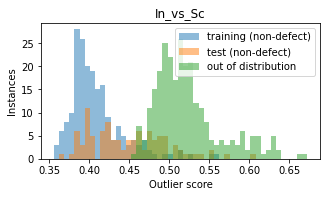

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/5
20/20 [==============================] - 6s 253ms/step - loss: 1.0613 - accuracy: 0.8500 - val_loss: 3.0473 - val_accuracy: 0.5000
Epoch 2/5
20/20 [==============================] - 3s 137ms/step - loss: 0.9690 - accuracy: 0.5656
Epoch 3/5
20/20 [==============================] - 3s 139ms/step - loss: 0.0533 - accuracy: 0.9688
Epoch 4/5
20/20 [==============================] - 4s 184ms/step - loss: 0.0151 - accuracy: 1.0000
Epoch 5/5
20/20 [==============================] - 4s 189ms/step - loss: 0.0079 - accuracy: 1.0000
Found 200 images belonging to 2 classes.
Found 400 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<Figure size 432x288 with 0 Axes>

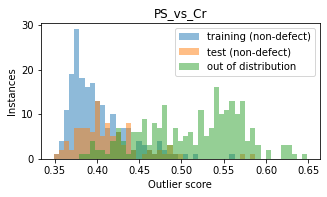

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/5
20/20 [==============================] - 6s 253ms/step - loss: 0.2931 - accuracy: 0.8500 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 2/5
20/20 [==============================] - 3s 137ms/step - loss: 8.8922e-04 - accuracy: 1.0000
Epoch 3/5
20/20 [==============================] - 3s 138ms/step - loss: 3.8466e-04 - accuracy: 1.0000
Epoch 4/5
20/20 [==============================] - 3s 136ms/step - loss: 3.4074e-04 - accuracy: 1.0000
Epoch 5/5
20/20 [==============================] - 3s 136ms/step - loss: 3.2024e-04 - accuracy: 1.0000
Found 200 images belonging to 2 classes.
Found 400 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<Figure size 432x288 with 0 Axes>

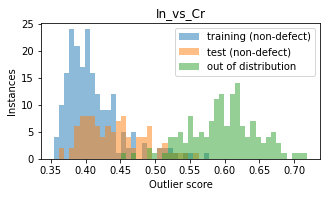

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/5
20/20 [==============================] - 6s 254ms/step - loss: 0.9208 - accuracy: 0.7125 - val_loss: 0.1140 - val_accuracy: 0.9625
Epoch 2/5
20/20 [==============================] - 3s 135ms/step - loss: 0.0143 - accuracy: 0.9906
Epoch 3/5
20/20 [==============================] - 3s 137ms/step - loss: 0.0039 - accuracy: 0.9969
Epoch 4/5
20/20 [==============================] - 3s 137ms/step - loss: 5.4934e-04 - accuracy: 1.0000
Epoch 5/5
20/20 [==============================] - 3s 137ms/step - loss: 8.9297e-04 - accuracy: 1.0000
Found 200 images belonging to 2 classes.
Found 400 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<Figure size 432x288 with 0 Axes>

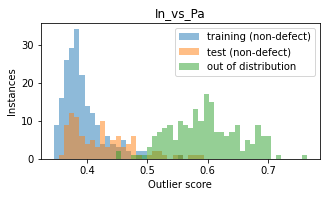

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/5
20/20 [==============================] - 6s 229ms/step - loss: 1.5759 - accuracy: 0.5688 - val_loss: 0.6311 - val_accuracy: 0.6125
Epoch 2/5
20/20 [==============================] - 3s 138ms/step - loss: 0.1472 - accuracy: 0.8687
Epoch 3/5
20/20 [==============================] - 3s 135ms/step - loss: 0.0376 - accuracy: 0.9875
Epoch 4/5
20/20 [==============================] - 3s 138ms/step - loss: 0.0120 - accuracy: 1.0000
Epoch 5/5
20/20 [==============================] - 3s 136ms/step - loss: 0.0077 - accuracy: 1.0000
Found 200 images belonging to 2 classes.
Found 400 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<Figure size 432x288 with 0 Axes>

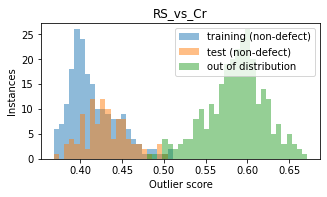

In [ ]:


dims = 1024 # dimensionality for the feature embedding 
img_width=200
img_height=200

batch_size=16
epochs = 10


# Performing experiment I in the paper
# (Note that there is some variation in the results, due to differences in the random sampling process)

# define pairs of classes for training the supervised classifier and respective, remaining four out-of-distribution classes 
CLASSES_SETS =[
    [['In', 'Sc'], ['Cr', 'PS', 'Pa', 'RS']],
    [['PS', 'Cr'], ['In', 'Sc', 'Pa', 'RS']],
    [['In', 'Cr'], ['Sc', 'PS', 'Pa', 'RS']],
    [['In', 'Pa'], ['Cr', 'PS', 'Sc', 'RS']],
    [['RS', 'Cr'], ['Sc', 'PS', 'Pa', 'In']]
]

df = pd.DataFrame()

for j, class_sets in enumerate(CLASSES_SETS):
    
    classifier_classes = class_sets[0]
    out_of_distribution_classes = class_sets[1]

    # create supervised binary classifier
    classifier = Classifier(dims, img_width, img_height)
    classifier.train(train_dir, classifier_classes, batch_size = batch_size, epochs = epochs, optimizer="adam", 
                     loss='categorical_crossentropy', metrics=['accuracy'], use_class_weights = False)

    # # list all data in history
    # print(classifier.history.history.keys())
    # # summarize history for accuracy
    # plt.plot(classifier.history.history['accuracy'])
    # plt.plot(classifier.history.history['val_accuracy'])
    # plt.title('model accuracy')
    # plt.ylabel('accuracy')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    
    # # summarize history for loss
    # plt.plot(classifier.history.history['loss'])
    # plt.plot(classifier.history.history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    
    probabilities = classifier.predict_generator(generator=classifier.train_generator)
    y_pred = np.argmax(probabilities,axis=1)
    y_true = classifier.train_generator.classes
    acc_train = accuracy_score(y_true, y_pred)

    val_generator=classifier.train_datagen.flow_from_directory(validation_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    classes=classifier_classes)

    probabilities = classifier.predict_generator(generator=val_generator)
    y_pred = np.argmax(probabilities, axis=1)
    y_true = val_generator.classes
    acc_test = accuracy_score(y_true, y_pred)

    ###

    val_generator = classifier.train_datagen.flow_from_directory(validation_dir,
                                                                target_size=(img_width, img_height),
                                                                batch_size=batch_size,
                                                                class_mode='categorical',
                                                                shuffle=False,
                                                                classes=out_of_distribution_classes)

    probabilities = classifier.predict_generator(generator=val_generator)
    y_pred = np.argmax(probabilities, axis=1)
    preds = Counter(y_pred)
    
    # monitor false non-defect class predictions (type II errors) 
    idx_outlier = np.where(y_pred == 0) # [np.where(y_pred == 0), np.where(y_pred == 1)]

    # create classifier supervision model 
    supervisor = ClassifierSupervision(classifier)

    # train a model on non defect class 
    class_non_defect = classifier_classes[0]  
    X_train, y_train = prepare(train_dir, [class_non_defect], classifier, supervisor)

    x_train = X_train[class_non_defect]
    supervisor.fit(x_train)
    hist = abs(supervisor.predict(x_train))
    mad = stats.median_absolute_deviation(hist)
    m = np.median(hist)
    mad35 = m + 3.5 * mad

    # prepare test and out-of-distribution
    X_test, y_test = prepare(validation_dir, CLASSES, classifier, supervisor)
    x_test = X_test[class_non_defect]
    hist_test = abs(supervisor.predict(x_test))

    x_defect = np.vstack((X_test[c] for c in out_of_distribution_classes))
    hist_defect = abs(supervisor.predict(x_defect))[idx_outlier]

    recovery = len(np.where(hist_defect >= mad35)[0]) / len(hist_defect) * 100

    if len(hist_defect) > 0:
        _, p_test_ks = stats.ks_2samp(hist, hist_test)
        _, p_defect_ks = stats.ks_2samp(hist, hist_defect)

        df = df.append({"id": str(j),
                        "class_non_defect": class_non_defect,
                        "class_defect": classifier_classes[1],
                        "acc_train": acc_train,
                        "acc_test": acc_test,
                        "normal": preds[0] / len(y_pred),
                        "defect": preds[1] / len(y_pred),
                        "p_ks_test": p_test_ks,
                        "p_ks_defect": p_defect_ks,
                        "median": m,
                        "mad": mad,
                        "mad35": mad35,
                        "type_II_recovery": recovery
                        }, ignore_index=True)


        file = f"tmp/{str(j)}_{class_non_defect}_vs_{classifier_classes[1]}.png"

        plt.clf()
        plt.figure(figsize=(5, 2.5))
        bins = np.linspace(min([min(hist), min(hist_test), min(hist_defect)]), 
                            max([max(hist), max(hist_test), max(hist_defect)]), 50)
        plt.hist(hist, bins, alpha=0.5, label='training (non-defect)')
        plt.hist(hist_test, bins, alpha=0.5, label='test (non-defect)')
        plt.hist(hist_defect, bins, alpha=0.5, label='out of distribution')
        plt.legend(loc='upper right')
        plt.xlabel("Outlier score")
        plt.ylabel("Instances")
        
        plt.title(f"Outlier estimation for {class_non_defect} vs {classifier_classes[1]} classifier")
        plt.show()
        #plt.savefig(file)
        #plt.close()

df.to_csv("tmp/df.csv")


In [ ]:
# print results for all five experiments stored in dataframe df 
# Note: the field type_II_recoverate shows the rate (in percentage) of identified false non-defect classifications
print(df)

  id class_non_defect class_defect  acc_train  acc_test  normal  defect  \
0  0               In           Sc   0.996875     0.995  0.6750  0.3250   
1  1               PS           Cr   1.000000     0.995  0.5650  0.4350   
2  2               In           Cr   1.000000     1.000  0.3625  0.6375   
3  3               In           Pa   1.000000     1.000  0.4875  0.5125   
4  4               RS           Cr   1.000000     0.995  0.6875  0.3125   

      p_ks_test   p_ks_defect    median       mad     mad35  type_II_recovery  
0  9.021561e-12  7.771561e-16  0.400610  0.024655  0.486902          0.844444  
1  3.906118e-03  1.332268e-15  0.392586  0.027891  0.490203          0.632743  
2  1.102992e-07  8.881784e-16  0.400380  0.029729  0.504431          0.965517  
3  1.102992e-07  8.881784e-16  0.383043  0.024097  0.467381          0.989744  
4  1.147519e-06  8.881784e-16  0.408753  0.025918  0.499466          0.989091  
